# 🧮 SQL-Based Sales Performance Analysis – Online Retail II
## **Data Science and Machine Learning Bootcamp – Ironhack Puerto Rico**
### 📓 Notebook: `3_sql_analysis_sales_performance_online_retail_ii.ipynb`

#### 📊 Description: Answer business questions using SQL queries on the normalized relational tables of the Online Retail II dataset  
📅 **Date:** December 20, 2024  
👩‍💻 **Author:** Ginosca Alejandro Dávila

---

## 📌 Notebook Overview

This notebook focuses on **answering business questions using SQL** with data from the **normalized relational version** of the Online Retail II dataset.

We’ll write SQL queries to:
- Analyze sales performance trends  
- Explore customer and product behavior  
- Segment customers using RFM metrics  

The analysis is based on the four relational `.csv` tables (`customers`, `products`, `invoices`, `invoice_items`) exported from `1_data_cleaning_online_retail_ii.ipynb` and validated for SQL use.

---

## 📂 Input Data

📁 `cleaned_data/` — Cleaned datasets ready for SQL:
- `customers.csv` → One row per customer (`customer_id`, `country`)
- `products.csv` → Unique products (`stock_code`, `description`, `unit_price`)
- `invoices.csv` → One row per invoice (`invoice_no`, `invoice_date`, `customer_id`)
- `invoice_items.csv` → One row per item per invoice (`invoice_no`, `stock_code`, `quantity`, `unit_price`, `line_revenue`)

These datasets form a relational schema and will be imported into a **temporary SQLite database** to support SQL querying from within this notebook.

---

## 🗂️ Output Folder Structure

To maintain a clean and modular structure for SQL analysis, we use the following folders inside the project’s `sql/` directory:

| Folder                          | Purpose                                                       |
|---------------------------------|---------------------------------------------------------------|
| `sql/scripts/`                  | Reusable `.sql` scripts (schema creation, standalone queries) |
| `sql_outputs/notebook_outputs/`         | Outputs (CSVs) generated from this notebook’s SQLite queries  |
| `sql/mysql_outputs/`            | Results manually exported from MySQL Workbench (later phase)  |

All query results in this notebook will be saved to `sql_outputs/notebook_outputs/`.

---

## 🎯 Goals

✔ Translate EDA insights into SQL queries  
✔ Answer key business questions with aggregations, joins, filtering, and window functions  
✔ Segment customers using **Recency, Frequency, and Monetary (RFM)** metrics  
✔ Prepare for future SQL dashboards, segmentation, and clustering

---

## 🧠 Business Questions to Answer

### 📈 Sales Performance
1. What is the monthly revenue trend from 2009 to 2011?  
2. What are the top 10 best-selling products by total revenue?  
3. Which invoices had the highest total transaction value?  

### 🌍 Country & Regional Insights
4. Which countries generate the most revenue?  
5. Do customer behaviors differ by country? *(e.g., avg. spend or frequency)*

### 👤 Customer Insights
6. How many customers made only one purchase?  
7. What is the average order value per customer?  
8. Who are the top 10 customers by total spend?

### 🧠 Customer Segmentation (RFM Analysis)
9. How recently has each customer made a purchase? *(Recency)*  
10. How frequently has each customer purchased? *(Frequency)*  
11. How much revenue has each customer generated? *(Monetary)*  
12. How can we segment customers based on RFM scores using SQL?  
    - 🟢 Loyal  
    - 🟡 High-Value  
    - 🔴 At-Risk  
    - 🔵 New / One-time Buyers

---

## 🔧 Setup

We will load the cleaned `.csv` files into a temporary in-memory **SQLite database** for interactive querying.  
Later in the project, queries may also be translated to **MySQL Workbench** to simulate a production SQL environment.

Next: Mount Google Drive and load the normalized tables to begin querying.


---

## 📂 Step 1: Mount Google Drive

To begin, we need to mount Google Drive to access the cleaned datasets stored in the project directory:

📁 `My Drive > Colab Notebooks > Portfolio Projects > Online Retail II > cleaned_data`

This step ensures we can load the **four normalized tables**, which support SQL-based analysis:

- `customers.csv`
- `products.csv`
- `invoices.csv`
- `invoice_items.csv`

> 🔍 Note: We will not use the flat file `cleaned_online_retail_II.csv` in this notebook.
> It was used in the EDA phase and is not required for SQL queries based on the normalized schema.


In [ ]:
import sys
import os

# ✅ Safe print to avoid encoding issues in some terminals
def safe_print(text):
    try:
        print(text)
    except UnicodeEncodeError:
        print(text.encode("ascii", errors="ignore").decode())

# ✅ Check if running inside Google Colab
def is_colab():
    return 'google.colab' in sys.modules

# ✅ Helper to find local project root based on known folders
def find_project_root(start_dir, target_subdirs=('cleaned_data', 'notebooks'), max_depth=5):
    """Search upward for a directory containing known project subfolders"""
    current = start_dir
    for _ in range(max_depth):
        if all(os.path.exists(os.path.join(current, sub)) for sub in target_subdirs):
            return current
        parent = os.path.abspath(os.path.join(current, '..'))
        if parent == current:
            break
        current = parent
    raise FileNotFoundError("❌ Could not find project root with expected structure.")

# 🔧 Set base path depending on environment
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')

    default_path = 'MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql'
    full_default_path = os.path.join('/content/drive', default_path)

    if os.path.exists(full_default_path):
        project_base_path = full_default_path
        safe_print(f"✅ Colab project path set to: {project_base_path}")
    else:
        safe_print("\n📂 Default path not found. Please input the relative path to your project inside Google Drive.")
        safe_print("👉 Example: 'MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql'")
        user_path = input("📥 Your path: ").strip()
        project_base_path = os.path.join('/content/drive', user_path)

        if not os.path.exists(project_base_path):
            raise FileNotFoundError(f"❌ Path does not exist: {project_base_path}\nPlease check your input.")

        safe_print(f"✅ Colab project path set to: {project_base_path}")

else:
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        script_dir = os.getcwd()

    try:
        project_base_path = find_project_root(script_dir)
        safe_print(f"✅ Local environment detected. Base path set to: {project_base_path}")
    except FileNotFoundError as e:
        safe_print(str(e))
        raise

# 📁 Path to cleaned relational data
cleaned_data_path = os.path.join(project_base_path, 'cleaned_data')

# ✅ List of expected files for validation
expected_files = [
    'customers.csv',
    'products.csv',
    'invoices.csv',
    'invoice_items.csv'
]

# 📂 Check for the presence of all expected CSV files
missing_files = []
for file in expected_files:
    full_path = os.path.join(cleaned_data_path, file)
    if not os.path.exists(full_path):
        missing_files.append(file)

# 🧾 Display results
if not missing_files:
    safe_print(f"✅ All cleaned data files found in: {cleaned_data_path}")
else:
    safe_print("❌ Missing files:")
    for mf in missing_files:
        safe_print(f" - {mf}")


Mounted at /content/drive
✅ Colab project path set to: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql
✅ All cleaned data files found in: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/cleaned_data


---

## 📥 Step 2: Import Libraries and Load Normalized Tables

We now import the required libraries and load the **normalized relational tables** created in the data cleaning phase:

📁 `cleaned_data/`  
- `customers.csv`
- `products.csv`  
- `invoices.csv`
- `invoice_items.csv`

These tables will serve as the **foundation for SQL-style querying** to answer key business questions and calculate performance metrics.

> 💡 `cleaned_online_retail_II.csv` is not used in this notebook.


In [ ]:
# 📦 Import core libraries
import pandas as pd
import os

# 📁 Define paths to relational tables
clean_path = os.path.join(project_base_path, 'cleaned_data')
customers_path = os.path.join(clean_path, 'customers.csv')
products_path = os.path.join(clean_path, 'products.csv')
invoices_path = os.path.join(clean_path, 'invoices.csv')
invoice_items_path = os.path.join(clean_path, 'invoice_items.csv')

# 📥 Load the relational datasets with error handling
try:
    customers_df = pd.read_csv(customers_path)
    products_df = pd.read_csv(products_path)
    invoices_df = pd.read_csv(invoices_path, parse_dates=['invoice_date'])
    invoice_items_df = pd.read_csv(invoice_items_path)

    safe_print("✅ All normalized relational tables loaded successfully.")
    safe_print(f"📄 customers.csv → {customers_df.shape}")
    safe_print(f"📄 products.csv → {products_df.shape}")
    safe_print(f"📄 invoices.csv → {invoices_df.shape}")
    safe_print(f"📄 invoice_items.csv → {invoice_items_df.shape}")

except FileNotFoundError as e:
    safe_print(f"❌ File not found: {e}")
    raise

except Exception as e:
    safe_print("❌ An unexpected error occurred while loading relational datasets.")
    raise


✅ All normalized relational tables loaded successfully.
📄 customers.csv → (5852, 2)
📄 products.csv → (4624, 3)
📄 invoices.csv → (36607, 3)
📄 invoice_items.csv → (766226, 5)


---

## ✅ Step 2 Summary – Relational Tables Loaded

All four **normalized relational tables** were successfully loaded and validated:

| Table             | Shape           | Description                                   |
|------------------|-----------------|-----------------------------------------------|
| `customers.csv`  | (5,852 rows × 2 cols)  | One row per unique customer (`customer_id`, `country`) |
| `products.csv`   | (4,624 rows × 3 cols)  | Unique product catalog (`stock_code`, `description`, `unit_price`) |
| `invoices.csv`   | (36,607 rows × 3 cols) | One row per invoice (`invoice_no`, `invoice_date`, `customer_id`) |
| `invoice_items.csv` | (766,226 rows × 5 cols) | Detailed transactions (`invoice_no`, `stock_code`, `quantity`, `unit_price`, `line_revenue`) |

> 📌 These tables form the **foundation for all SQL-based analysis** in this notebook.  
> We will use them to join customer, product, invoice, and transaction-level information.


---

## 📋 Step 3: Table Preview & Schema Overview

Before starting SQL-based analysis, we briefly inspect the four loaded datasets to confirm:

- ✅ File integrity and shape
- ✅ Column names and data types
- ✅ Structural alignment with the project schema

This ensures that all tables are ready for structured querying and that the relational design from the cleaning phase remains intact.

We'll preview:

- `customers.csv` — 1 row per customer  
- `products.csv` — 1 row per product  
- `invoices.csv` — 1 row per invoice  
- `invoice_items.csv` — 1 row per item in each invoice  

---


In [ ]:
import io

# ✅ Display fallback for scripts
try:
    display
except NameError:
    def display(x):
        print(x.to_string() if isinstance(x, pd.DataFrame) else str(x))

# 🔍 Helper to inspect basic structure
def preview_table(df, name="Table", preview_rows=5):
    safe_print(f"📄 Previewing: {name}")
    safe_print("=" * 50)
    safe_print(f"🔹 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    safe_print("🔹 Column Names:")
    safe_print(df.columns.tolist())

    safe_print(f"\n🔹 First {preview_rows} rows:")
    display(df.head(preview_rows))

    safe_print("\n🔹 Data Types and Non-Null Counts:")
    buffer = io.StringIO()
    df.info(buf=buffer)
    safe_print(buffer.getvalue())
    safe_print("=" * 50 + "\n")

# 🔁 Preview each table
preview_table(customers_df, name="customers.csv")
preview_table(products_df, name="products.csv")
preview_table(invoices_df, name="invoices.csv")
preview_table(invoice_items_df, name="invoice_items.csv")


📄 Previewing: customers.csv
🔹 Shape: 5852 rows × 2 columns
🔹 Column Names:
['customer_id', 'country']

🔹 First 5 rows:


,customer_id,country
0,13085,united kingdom
1,13078,united kingdom
2,15362,united kingdom
3,18102,united kingdom
4,12682,france



🔹 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  5852 non-null   int64 
 1   country      5852 non-null   object
dtypes: int64(1), object(1)
memory usage: 91.6+ KB


📄 Previewing: products.csv
🔹 Shape: 4624 rows × 3 columns
🔹 Column Names:
['stock_code', 'description', 'unit_price']

🔹 First 5 rows:


,stock_code,description,unit_price
0,10002,inflatable political globe,0.85
1,10080,groovy cactus inflatable,0.85
2,10109,bendy colour pencils,0.42
3,10120,doggy rubber,0.21
4,10123C,hearts wrapping tape,0.65



🔹 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   stock_code   4624 non-null   object 
 1   description  4624 non-null   object 
 2   unit_price   4624 non-null   float64
dtypes: float64(1), object(2)
memory usage: 108.5+ KB


📄 Previewing: invoices.csv
🔹 Shape: 36607 rows × 3 columns
🔹 Column Names:
['invoice_no', 'invoice_date', 'customer_id']

🔹 First 5 rows:


,invoice_no,invoice_date,customer_id
0,489434,2009-12-01 07:45:00,13085
1,489435,2009-12-01 07:46:00,13085
2,489436,2009-12-01 09:06:00,13078
3,489437,2009-12-01 09:08:00,15362
4,489438,2009-12-01 09:24:00,18102



🔹 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36607 entries, 0 to 36606
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    36607 non-null  int64         
 1   invoice_date  36607 non-null  datetime64[ns]
 2   customer_id   36607 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 858.1 KB


📄 Previewing: invoice_items.csv
🔹 Shape: 766226 rows × 5 columns
🔹 Column Names:
['invoice_no', 'stock_code', 'quantity', 'unit_price', 'line_revenue']

🔹 First 5 rows:


,invoice_no,stock_code,quantity,unit_price,line_revenue
0,489434,21232,24,1.25,30.0
1,489434,21523,10,5.95,59.5
2,489434,21871,24,1.25,30.0
3,489434,22041,48,2.10,100.8
4,489434,22064,24,1.65,39.6



🔹 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766226 entries, 0 to 766225
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    766226 non-null  int64  
 1   stock_code    766226 non-null  object 
 2   quantity      766226 non-null  int64  
 3   unit_price    766226 non-null  float64
 4   line_revenue  766226 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 29.2+ MB




---

## ✅ Step 3 Summary – Table Structure & Schema Validation

All four normalized tables were successfully previewed, confirming structural integrity and readiness for SQL-based analysis.

| Table              | Key Columns                          | Notes |
|-------------------|--------------------------------------|-------|
| `customers.csv`    | `customer_id`, `country`             | Unique customers with associated country |
| `products.csv`     | `stock_code`, `description`, `unit_price` | Product catalog with prices |
| `invoices.csv`     | `invoice_no`, `invoice_date`, `customer_id` | One row per transaction issued to a customer |
| `invoice_items.csv`| `invoice_no`, `stock_code`, `quantity`, `unit_price`, `line_revenue` | Detailed line items per invoice |

> ✅ **All tables match the relational schema defined during the data cleaning phase** and contain no missing values.  
> The next step is to create a temporary in-memory SQLite database and load these tables for structured SQL querying.


---

## 🗃️ Step 4: Create SQLite Schema & Load Data

To execute SQL queries on our cleaned datasets, we now create a temporary **in-memory SQLite database** using `SQLAlchemy`.  

Each `.csv` file is loaded into a corresponding SQL table:

| CSV File           | Table Name        |
|--------------------|-------------------|
| `customers.csv`    | `customers`       |
| `products.csv`     | `products`        |
| `invoices.csv`     | `invoices`        |
| `invoice_items.csv`| `invoice_items`   |

This relational schema allows us to write SQL queries that join across customer, product, invoice, and item-level data.

---


In [ ]:
import sqlite3
from sqlalchemy import create_engine

# ✅ Create SQLite in-memory database
engine = create_engine('sqlite://', echo=False)

# 🗃️ Load DataFrames into SQL tables
try:
    customers_df.to_sql('customers', con=engine, index=False, if_exists='replace')
    products_df.to_sql('products', con=engine, index=False, if_exists='replace')
    invoices_df.to_sql('invoices', con=engine, index=False, if_exists='replace')
    invoice_items_df.to_sql('invoice_items', con=engine, index=False, if_exists='replace')
    safe_print("✅ All tables successfully loaded into SQLite in-memory database.")
except Exception as e:
    safe_print("❌ Error loading tables into SQLite:")
    safe_print(str(e))
    raise


✅ All tables successfully loaded into SQLite in-memory database.


---

## 🧩 Step 5: SQL Table & Column Guide

Below is a reference guide for the structure of our normalized relational schema.  
This schema was created during the data cleaning phase and now exists as SQL tables within the in-memory SQLite database.

| Table           | Column         | Description                            | Data Type       | Key Type     | Constraints                    |
|-----------------|----------------|----------------------------------------|------------------|--------------|--------------------------------|
| `customers`     | `customer_id`  | Unique ID for each customer            | `INT`            | Primary Key  | `NOT NULL`, `UNIQUE`           |
| `customers`     | `country`      | Country where the customer resides     | `VARCHAR(100)`   | –            | `NOT NULL`                     |
| `products`      | `stock_code`   | Product identifier                     | `VARCHAR(10)`    | Primary Key  | `NOT NULL`, `UNIQUE`           |
| `products`      | `description`  | Product name                           | `TEXT`           | –            | `NOT NULL`                     |
| `products`      | `unit_price`   | Unit selling price (in GBP)            | `DECIMAL(10,2)`  | –            | `NOT NULL`, `> 0`              |
| `invoices`      | `invoice_no`   | Unique invoice ID                      | `VARCHAR(10)`    | Primary Key  | `NOT NULL`, `UNIQUE`           |
| `invoices`      | `invoice_date` | Timestamp of invoice creation          | `DATETIME`       | –            | `NOT NULL`                     |
| `invoices`      | `customer_id`  | Customer who placed the invoice        | `INT`            | Foreign Key  | `NOT NULL`, → `customers`      |
| `invoice_items` | `invoice_no`   | Invoice reference                      | `VARCHAR(10)`    | Foreign Key  | `NOT NULL`, → `invoices`       |
| `invoice_items` | `stock_code`   | Product reference                      | `VARCHAR(10)`    | Foreign Key  | `NOT NULL`, → `products`       |
| `invoice_items` | `quantity`     | Units sold for that product            | `INT`            | –            | `NOT NULL`, `> 0`              |
| `invoice_items` | `unit_price`   | Price per unit at the time of sale     | `DECIMAL(10,2)`  | –            | `NOT NULL`, `> 0`              |
| `invoice_items` | `line_revenue` | Calculated as quantity × unit_price    | `DECIMAL(12,2)`  | –            | Derived, `>= 0`                |

---

### 🔑 Composite Primary Key

- `invoice_items`: (`invoice_no`, `stock_code`)  
  → Together, these uniquely identify a product line within an invoice.

---

### 🧭 Relational Diagram (ERD)

The ERD below illustrates the relationships between the four normalized tables used in this notebook.

> 📝 This image renders only in Jupyter/Colab environments.  
> If you're viewing the `.py` script, refer to: `images/online_retail_ii_erd.png`

---


✅ ERD image copied to /content/


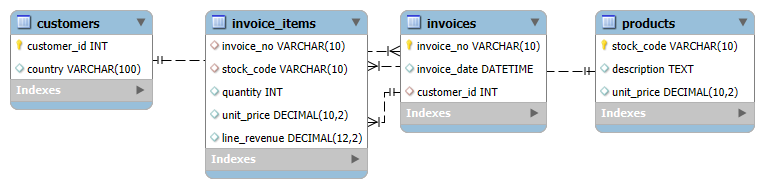

In [ ]:
import shutil
from IPython.display import Image, display

# ✅ Set path to ERD image inside project folder
drive_img_path = os.path.join(project_base_path, 'images', 'online_retail_ii_erd.png')

# ✅ In Colab: copy image to /content for rendering
if is_colab():
    colab_img_path = '/content/online_retail_ii_erd.png'

    if os.path.exists(drive_img_path):
        shutil.copyfile(drive_img_path, colab_img_path)
        safe_print("✅ ERD image copied to /content/")
    else:
        safe_print("❌ ERD image not found in Google Drive.")
else:
    colab_img_path = drive_img_path  # Use image directly in local/Jupyter

# 🖼️ Display the ERD image (in notebook environments)
try:
    display(Image(filename=colab_img_path))
except Exception as e:
    safe_print(f"❌ Could not display ERD image: {e}")


---

## 🧠 Step 6: Begin Answering Business Questions with SQL

Now that our normalized relational data is loaded into an in-memory SQLite database, we are ready to begin answering the core business questions using SQL.

We’ll use SQL queries to:
- Join across the `customers`, `products`, `invoices`, and `invoice_items` tables  
- Aggregate sales metrics  
- Explore customer behavior  
- Segment users with RFM scores  

> 🔎 All queries will be written using SQLAlchemy `.execute()` calls and results will be loaded into pandas DataFrames for inspection and export.  
>  
> 💾 Output files will be saved to:  
> 📁 `sql_outputs/notebook_outputs/` — for query results from this notebook  
> 📁 `sql/mysql_outputs/` — for queries rerun or adapted in MySQL Workbench (optional)  
>  
> This structure helps keep SQL results organized across different environments.

---

### 🚀 Let’s start with Sales Performance analysis!


---
## 📈 Step 7: Monthly Revenue Trend (Q1)

Our first business question focuses on understanding how revenue evolved over time.

### ❓ Q1. What is the monthly revenue trend from 2009 to 2011?

We will calculate the **total monthly revenue** by:
- Joining the `invoices` and `invoice_items` tables on `invoice_no`  
- Grouping by `invoice_date` (monthly)  
- Summing `line_revenue` for each month

This query will help uncover seasonal patterns, sales growth, and potential anomalies.

> 📁 Output will be saved to `sql_outputs/notebook_outputs/01_monthly_revenue_trend.csv`

---


In [ ]:
from sqlalchemy import text
import pandas as pd
import os

# 🔧 Setup export path
sql_output_dir = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs')
os.makedirs(sql_output_dir, exist_ok=True)

# 📝 SQL Query: Monthly revenue by month
monthly_revenue_query = text("""
SELECT
    strftime('%Y-%m', invoice_date) AS invoice_month,
    ROUND(SUM(line_revenue), 2) AS monthly_revenue,
    COUNT(DISTINCT invoice_no) AS monthly_invoices,
    ROUND(SUM(line_revenue) * 1.0 / COUNT(DISTINCT invoice_no), 2) AS avg_revenue_per_invoice
FROM invoices
JOIN invoice_items USING(invoice_no)
GROUP BY invoice_month
ORDER BY invoice_month;
""")

# 📊 Execute and load into DataFrame
monthly_revenue_df = pd.read_sql(monthly_revenue_query, con=engine)

# 👁️ Preview result
safe_print("📊 Monthly Revenue Trend:")
display(monthly_revenue_df)

# 💾 Save result to CSV
monthly_revenue_path = os.path.join(sql_output_dir, '01_monthly_revenue_trend.csv')
monthly_revenue_df.to_csv(monthly_revenue_path, index=False)
safe_print(f"✅ Saved: {monthly_revenue_path}")


📊 Monthly Revenue Trend:


,invoice_month,monthly_revenue,monthly_invoices,avg_revenue_per_invoice
0,2009-12,678029.57,1502,451.42
1,2010-01,533802.98,963,554.31
2,2010-02,497937.58,1093,455.57
3,2010-03,665973.67,1509,441.33
4,2010-04,585149.93,1316,444.64
5,2010-05,592734.13,1365,434.24
6,2010-06,629540.45,1482,424.79
7,2010-07,581487.96,1362,426.94
8,2010-08,594561.17,1276,465.96
9,2010-09,805544.81,1659,485.56


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/01_monthly_revenue_trend.csv


### 📊 Summary: Monthly Revenue Trend (SQL Output)

We calculated total monthly revenue from **December 2009 to December 2011** using SQL joins across the normalized `invoices` and `invoice_items` tables.

#### 🔍 Key Insights:
- 🛍️ Revenue peaks in **November** of both **2010 (£1.16M)** and **2011 (£1.14M)**, reflecting strong **pre-holiday sales activity**.
- 📉 Lower revenue in **January–February** each year suggests a typical **post-holiday slowdown**.
- 🔁 A repeating pattern of **Q4 strength** highlights a clear seasonal sales cycle.
- 📅 The value for **December 2011** appears lower because it is a **partial month** — the dataset only includes transactions through **December 9, 2011**.

> ⚖️ **Methodological Note**  
> SQL results show **strong alignment** with the EDA notebook. Any slight differences are solely due to **decimal precision** or **formatting**, with no substantive variation in totals or patterns.

This confirms consistency between the relational SQL queries and the flat-file EDA outputs — ensuring the integrity of our monthly revenue analysis.

---


---

## 💰 Step 8: Top 10 Best-Selling Products by Revenue (Q2)

### ❓ Q2. What are the top 10 best-selling products by total revenue?

To identify our best-performing products, we will:

- Join `invoice_items` with `products` using `stock_code`
- Group by `stock_code` and `description`
- Calculate total `line_revenue` per product
- Sort by descending revenue and show the top 10

This query reveals which SKUs are driving the most revenue — helping guide inventory planning, marketing focus, or bundling strategies.

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/02_top_products_by_revenue.csv`

---


In [ ]:
# 📊 Q2: Top 10 Products by Revenue
query_top_products = """
SELECT
    p.stock_code,
    p.description,
    ROUND(SUM(ii.line_revenue), 2) AS total_revenue,
    SUM(ii.quantity) AS total_quantity,
    ROUND(AVG(ii.unit_price), 2) AS avg_unit_price
FROM invoice_items AS ii
JOIN products AS p ON ii.stock_code = p.stock_code
GROUP BY p.stock_code, p.description
ORDER BY total_revenue DESC
LIMIT 10;
"""

# 🚀 Execute query
top_products_df = pd.read_sql_query(query_top_products, engine)

# 📋 Display result
safe_print("📊 Top 10 Best-Selling Products by Revenue:")
display(top_products_df)

# 💾 Save output
top_products_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '02_top_products_by_revenue.csv')
top_products_df.to_csv(top_products_path, index=False)
safe_print(f"✅ Saved: {top_products_path}")


📊 Top 10 Best-Selling Products by Revenue:


,stock_code,description,total_revenue,total_quantity,avg_unit_price
0,22423,regency cakestand 3 tier,277656.25,24124,12.46
1,85123A,white hanging heart t-light holder,247203.36,91814,2.87
2,23843,"paper craft , little birdie",168469.60,80995,2.08
3,85099B,jumbo bag red retrospot,167920.64,93436,1.96
4,84879,assorted colour bird ornament,124351.86,78234,1.68
5,47566,party bunting,103283.38,23460,4.77
6,23166,medium ceramic top storage jar,81416.73,77916,1.22
7,22086,paper chain kit 50's christmas,76598.18,28380,2.92
8,79321,chilli lights,69084.30,14843,5.15
9,22386,jumbo bag pink polkadot,67769.76,37338,1.97


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/02_top_products_by_revenue.csv


---

### 📊 Summary: Top 10 Products by Revenue (SQL Output)

The SQL query identifies the **top 10 products ranked by total revenue**, based on normalized `invoice_items` and `products` tables.

#### 🔍 Key Insights:

- 🥇 The **"regency cakestand 3 tier"** generated the most revenue: **£277,656.25**, with over **24,000 units** sold and an average unit price of **£12.46**.
- 🕯️ **"white hanging heart t-light holder"** also performed strongly, earning over **£247K** from more than **91,000 units**, indicating a **low-cost, high-volume** appeal.
- 🎁 The top products are mainly **decorative and seasonal items**, consistent with the company’s retail profile.
- 🧹 The SQL results show **close alignment with the EDA notebook**, confirming consistent aggregation and product-level revenue patterns.

This confirms a successful join across relational tables and highlights the **core items driving revenue** during the observed period.

---


---

## 🧾 Step 9: Top 10 Highest-Value Invoices (Q3)

### ❓ Q3. Which invoices had the highest total transaction value?

To identify the most valuable transactions, we will:

- Use the `invoice_items` table
- Join with `invoices` to retrieve `customer_id` and `invoice_date`
- Group by `invoice_no`, `customer_id`, and `invoice_date`
- Aggregate the total `line_revenue` per invoice
- Sort by total invoice revenue in descending order
- Display the top 10 highest-value invoices

This analysis reveals which individual transactions brought in the most revenue — useful for **auditing large sales**, identifying **high-value clients**, or evaluating **bulk purchase behavior**.

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/03_top_invoices_by_value.csv`

---


In [ ]:
# 📊 Q3: Top 10 Invoices by Total Transaction Value
query_top_invoices = """
SELECT
    ii.invoice_no,
    ROUND(SUM(ii.line_revenue), 2) AS total_invoice_revenue,
    COUNT(ii.stock_code) AS invoice_items,
    c.customer_id,
    i.invoice_date
FROM invoice_items AS ii
JOIN invoices AS i ON ii.invoice_no = i.invoice_no
JOIN customers AS c ON i.customer_id = c.customer_id
GROUP BY ii.invoice_no, i.customer_id, i.invoice_date
ORDER BY total_invoice_revenue DESC
LIMIT 10;
"""

# 🚀 Execute query
top_invoices_df = pd.read_sql_query(query_top_invoices, engine)

# 📋 Display result
safe_print("📊 Top 10 Highest-Value Invoices:")
display(top_invoices_df)

# 💾 Save output
top_invoices_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '03_top_invoices_by_value.csv')
top_invoices_df.to_csv(top_invoices_path, index=False)
safe_print(f"✅ Saved: {top_invoices_path}")


📊 Top 10 Highest-Value Invoices:


,invoice_no,total_invoice_revenue,invoice_items,customer_id,invoice_date
0,581483,168469.60,1,16446,2011-12-09 09:15:00.000000
1,541431,77183.60,1,12346,2011-01-18 10:01:00.000000
2,493819,44051.60,94,14156,2010-01-07 12:34:00.000000
3,556444,38970.00,1,15098,2011-06-10 15:28:00.000000
4,524181,33167.80,13,17450,2010-09-27 16:59:00.000000
5,567423,31698.16,12,17450,2011-09-20 11:05:00.000000
6,526934,26007.08,15,18102,2010-10-14 09:46:00.000000
7,515944,22863.36,17,18102,2010-07-15 15:29:00.000000
8,556917,22775.93,138,12415,2011-06-15 13:37:00.000000
9,572209,22206.00,7,18102,2011-10-21 12:08:00.000000


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/03_top_invoices_by_value.csv


---

### 🧾 Summary: Top 10 Highest-Value Invoices  (SQL Output)

This SQL query identifies the **10 highest-value invoices**, calculated by summing `line_revenue` from all products in each invoice.

| Metric                  | Insight                                                                                     |
|-------------------------|---------------------------------------------------------------------------------------------|
| 🧾 **Highest Invoice**   | Invoice `581483` totals **£168,470** from a **single item**, which may indicate a **bulk order** or **data anomaly**. |
| 💰 **Invoice Range**     | Top 10 invoices range from **£22,206** to **£168,470** in value, with most between **£22k–£77k**. |
| 📦 **Invoice Size**      | Some invoices contain **over 130 items**, while others just **1 or 2**, reflecting varying customer types. |
| 👤 **Repeat Customers**  | Customers `18102`, `17450`, and `12415` show up multiple times, hinting at **loyal high-spend buyers**. |
| 🗓️ **Invoice Timing**    | High-value transactions are distributed across **2010–2011**, with **no strong seasonality** observed. |
| ⚠️ **Potential Anomalies** | Some invoices with extreme revenue per item merit **manual review** for pricing accuracy or data entry errors. |

> ✅ The SQL output matches the EDA notebook results, validating the join and aggregation logic using the normalized schema.

---

---

## 🌍 Step 9: Revenue by Country (Q4)

### ❓ Q4. Which countries generate the most revenue?

To calculate total revenue by country, we must trace each sale to the customer who placed the order. The `country` field is located in the `customers` table, so we'll follow this join path:

- 🔗 Join `invoice_items` ➡️ `invoices` using `invoice_no`
- 🔗 Then join `invoices` ➡️ `customers` using `customer_id`
- 📊 Group by `country` (from `customers`)
- 💰 Calculate total `line_revenue` per country
- ⬇️ Sort results in descending order of total revenue

We generate **two outputs** for this analysis:

- 📂 **All countries included** (including the UK)
- 📂 **UK excluded** to focus on international performance

This analysis helps understand **geographic revenue distribution**, supporting better decisions around regional marketing, logistics, and strategic investment.

> 📁 Outputs will be saved to:  
> - `sql_outputs/notebook_outputs/04_revenue_by_country.csv`  
> - `sql_outputs/notebook_outputs/04_revenue_by_country_excl_uk.csv`

---


In [ ]:
# 📊 Q4a: Total Revenue by Country (Includes UK)
query_revenue_by_country = """
SELECT
    c.country,
    ROUND(SUM(ii.line_revenue), 2) AS total_revenue,
    COUNT(DISTINCT i.invoice_no) AS num_invoices,
    ROUND(SUM(ii.line_revenue) * 1.0 / COUNT(DISTINCT i.invoice_no), 2) AS avg_invoice_value
FROM invoice_items AS ii
JOIN invoices AS i ON ii.invoice_no = i.invoice_no
JOIN customers AS c ON i.customer_id = c.customer_id
GROUP BY c.country
ORDER BY total_revenue DESC;
"""

# 🚀 Execute query
revenue_by_country_df = pd.read_sql_query(query_revenue_by_country, engine)

# 📋 Display result
safe_print("📋 Top Countries by Total Revenue (Includes UK):")
display(revenue_by_country_df.head(10))

# 💾 Save output
revenue_country_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '04_revenue_by_country.csv')
revenue_by_country_df.to_csv(revenue_country_path, index=False)
safe_print(f"✅ Saved: {revenue_country_path}")

# 📊 Q4b: Total Revenue by Country (Excludes UK)
query_revenue_by_country_excl_uk = """
SELECT
    c.country,
    ROUND(SUM(ii.line_revenue), 2) AS total_revenue,
    COUNT(DISTINCT i.invoice_no) AS num_invoices,
    ROUND(SUM(ii.line_revenue) * 1.0 / COUNT(DISTINCT i.invoice_no), 2) AS avg_invoice_value
FROM invoice_items AS ii
JOIN invoices AS i ON ii.invoice_no = i.invoice_no
JOIN customers AS c ON i.customer_id = c.customer_id
WHERE TRIM(LOWER(c.country)) != 'united kingdom'
GROUP BY c.country
ORDER BY total_revenue DESC;
"""

# 🚀 Execute query
revenue_by_country_excl_uk_df = pd.read_sql_query(query_revenue_by_country_excl_uk, engine)

# 📋 Display result
safe_print("📋 Top Countries by Total Revenue (Excludes UK):")
display(revenue_by_country_excl_uk_df.head(10))

# 💾 Save output
revenue_country_excl_uk_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '04_revenue_by_country_excl_uk.csv')
revenue_by_country_excl_uk_df.to_csv(revenue_country_excl_uk_path, index=False)
safe_print(f"✅ Saved: {revenue_country_excl_uk_path}")


📋 Top Countries by Total Revenue (Includes UK):


,country,total_revenue,num_invoices,avg_invoice_value
0,united kingdom,14289730.57,33374,428.17
1,eire,586626.08,528,1111.03
2,netherlands,549773.41,216,2545.25
3,germany,383191.95,752,509.56
4,france,309685.56,592,523.12
5,australia,168452.79,87,1936.24
6,spain,96399.08,137,703.64
7,switzerland,95543.29,90,1061.59
8,sweden,86045.14,98,878.01
9,denmark,66133.87,40,1653.35


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/04_revenue_by_country.csv
📋 Top Countries by Total Revenue (Excludes UK):


,country,total_revenue,num_invoices,avg_invoice_value
0,eire,586626.08,528,1111.03
1,netherlands,549773.41,216,2545.25
2,germany,383191.95,752,509.56
3,france,309685.56,592,523.12
4,australia,168452.79,87,1936.24
5,spain,96399.08,137,703.64
6,switzerland,95543.29,90,1061.59
7,sweden,86045.14,98,878.01
8,denmark,66133.87,40,1653.35
9,belgium,56787.90,144,394.36


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/04_revenue_by_country_excl_uk.csv


---

## 🌍 Summary: Revenue by Country (SQL Output)

This SQL analysis computes the **top 10 revenue-generating countries** by joining `invoice_items`, `invoices`, and `customers`. For each country, we calculate:

- Total revenue (`line_revenue`)
- Number of unique invoices
- Average revenue per invoice

| 📊 **Insight Category**             | **Key Observations**                                                                 |
|------------------------------------|--------------------------------------------------------------------------------------|
| 🇬🇧 **UK Dominance**                | The **United Kingdom** leads with **£14.3M** across **33,374 invoices**, confirming its role as the company’s **primary market**. |
| 🌍 **Top International Performers** | **Ireland (Eire)** and the **Netherlands** follow with over **£500K** in revenue and high average invoice values. |
| 💸 **High-Value Orders**           | The **Netherlands** shows the **highest average invoice value** at ~**£2,545**, indicating large bulk orders. |
| 📦 **Low-Volume, High-Impact**     | Countries like **Australia**, **Switzerland**, and **Denmark** contribute significantly despite fewer transactions. |
| 🌐 **Diversified European Reach**  | **Germany** and **France** combine high revenue with steady volume, anchoring the company’s **European footprint**. |

> ✅ The SQL outputs closely align with the EDA notebook, confirming the accuracy of relational joins and aggregations.

This geographic revenue breakdown supports **market segmentation**, helping inform strategies for **regional investment, logistics planning**, and **localized marketing**.

---


---

## 🌍 Step 10: Customer Behavior by Country (Q5)

### ❓ Q5. Do customer behaviors differ by country? (e.g., avg. spend or frequency)

To evaluate behavioral differences across regions, we analyze patterns of **purchase frequency** and **spending habits** using SQL. This allows us to understand customer dynamics beyond just revenue.

We will:

- 🔗 Join `invoice_items` ➡️ `invoices` ➡️ `customers` (using `invoice_no` and `customer_id`)
- 📊 Group by `country`
- 🧮 Aggregate the following:
  - Total revenue (`SUM(line_revenue)`)
  - Total number of invoices (`COUNT(DISTINCT invoice_no)`)
  - Total number of customers (`COUNT(DISTINCT customer_id)`)
- 🧾 Calculate:
  - **Avg. invoices per customer**
  - **Avg. revenue per customer**

This breakdown helps identify:

- Countries with **frequent buyers** or **loyal customers**
- Regions with **high-value clients**
- Markets with **low volume but premium purchase behavior**

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/05_customer_behavior_by_country.csv`

---


In [ ]:
# 📊 Q5: Customer Behavior by Country – Matching EDA Output
query_customer_behavior_by_country = """
SELECT
    c.country,
    COUNT(DISTINCT c.customer_id) AS num_customers,
    COUNT(DISTINCT i.invoice_no) AS num_invoices,
    ROUND(SUM(ii.line_revenue), 2) AS total_revenue,
    ROUND(COUNT(DISTINCT i.invoice_no) * 1.0 / COUNT(DISTINCT c.customer_id), 2) AS avg_invoices_per_customer,
    ROUND(SUM(ii.line_revenue) * 1.0 / COUNT(DISTINCT c.customer_id), 2) AS avg_revenue_per_customer
FROM invoice_items AS ii
JOIN invoices AS i USING(invoice_no)
JOIN customers AS c USING(customer_id)
GROUP BY c.country
ORDER BY total_revenue DESC;
"""

# 🚀 Execute query
customer_behavior_df = pd.read_sql_query(query_customer_behavior_by_country, engine)

# 📋 Display result
safe_print("📊 Customer Behavior by Country (SQL Output):")
display(customer_behavior_df.head(10))

# 💾 Save output
behavior_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '05_customer_behavior_by_country.csv')
customer_behavior_df.to_csv(behavior_path, index=False)
safe_print(f"✅ Saved: {behavior_path}")


📊 Customer Behavior by Country (SQL Output):


,country,num_customers,num_invoices,total_revenue,avg_invoices_per_customer,avg_revenue_per_customer
0,united kingdom,5334,33374,14289730.57,6.26,2678.99
1,eire,3,528,586626.08,176.00,195542.03
2,netherlands,22,216,549773.41,9.82,24989.70
3,germany,106,752,383191.95,7.09,3615.02
4,france,93,592,309685.56,6.37,3329.95
5,australia,14,87,168452.79,6.21,12032.34
6,spain,35,137,96399.08,3.91,2754.26
7,switzerland,22,90,95543.29,4.09,4342.88
8,sweden,19,98,86045.14,5.16,4528.69
9,denmark,9,40,66133.87,4.44,7348.21


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/05_customer_behavior_by_country.csv


---

### 📊 Summary: Customer Behavior by Country (SQL Output)

This output explores **average customer behavior** by country, measuring how many invoices each customer places and how much revenue they generate. These metrics help evaluate **market engagement** and **customer value** across regions.

| Insight Category               | Key Observations                                                                 |
|--------------------------------|----------------------------------------------------------------------------------|
| 🇬🇧 **UK Benchmark**                   | The UK has **5,334 customers** averaging **6.26 invoices** and **£2,679 revenue per customer** — a large and balanced primary market. |
| ☘️ **Ireland (Eire)**                | Just **3 customers** account for **528 invoices** and **~£195.5K per customer**, indicating **atypical behavior** (e.g., internal account or bulk buyer). |
| 🇳🇱 **Netherlands**                  | Engaged customers with **~9.82 invoices each** and **£24.9K per customer** — suggesting strong sales relationships and room for targeted growth. |
| 🇩🇪 🇫🇷 **Germany & France**           | Consistent volume and value with **6–7 invoices/customer** and **~£3.3K–£3.6K revenue** — mature and stable markets. |
| 🌍 **Switzerland, Sweden, Denmark** | Smaller customer bases, but **high revenue per customer** (over **£4K–£7K**) — ideal for **premium targeting strategies**. |

> ⚠️ **Note**: Ireland’s extreme values result from a very small sample (3 customers), which may distort averages due to **non-standard purchasing patterns**.

These patterns highlight geographic segments with either high customer value or untapped market potential.

📊 **Consistency Check**  
The SQL output closely aligns with the EDA results, confirming that joins and aggregations across the normalized relational model produce consistent and reliable metrics.

---


---

## 🧍 Step 11: One-Time vs. Repeat Customers (Q6)

### ❓ Q6. How many customers made only one purchase?

To evaluate **customer engagement and loyalty**, we categorize customers based on their purchase frequency, using invoice counts per customer as the key metric.

We calculate:

- **Single Purchase**: Customers with exactly one invoice  
- **Repeat Customer**: Customers with two or more invoices

These metrics are derived using the following SQL logic:

- Use the `invoices` table to count the number of unique `invoice_no` per `customer_id`  
- Use a **Common Table Expression (CTE)** to tag each customer based on their number of invoices  
- Aggregate the customer counts into two categories: `'Single Purchase'` and `'Repeat Customer'`  
- Calculate both raw counts and percentage distribution of each group

This segmentation supports:

- Identifying the proportion of customers who may be **churning** after one order  
- Informing **retention strategies**, such as loyalty incentives or follow-up campaigns  
- Measuring overall **customer engagement health**

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/06_one_time_vs_repeat_customers.csv`

---


In [ ]:
# 📝 SQL Query: Count of single vs. repeat customers with percentage
query_customer_type_summary = text("""
WITH invoice_counts AS (
    SELECT
        customer_id,
        COUNT(DISTINCT invoice_no) AS num_invoices
    FROM invoices
    GROUP BY customer_id
),
tagged_customers AS (
    SELECT
        CASE
            WHEN num_invoices = 1 THEN 'Single Purchase'
            ELSE 'Repeat Customer'
        END AS customer_type
    FROM invoice_counts
)
SELECT
    customer_type,
    COUNT(*) AS count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM tagged_customers), 2) AS percent
FROM tagged_customers
GROUP BY customer_type
ORDER BY customer_type DESC;
""")

# ▶️ Execute and load into DataFrame
customer_type_summary_df = pd.read_sql(query_customer_type_summary, con=engine)

# 👁️ Preview
safe_print("📊 One-Time vs. Repeat Customer Breakdown:")
display(customer_type_summary_df)

# 💾 Save the output
one_time_vs_repeat_path = os.path.join(sql_output_dir, '06_one_time_vs_repeat_customers.csv')
customer_type_summary_df.to_csv(one_time_vs_repeat_path, index=False)
safe_print(f"✅ Saved: {one_time_vs_repeat_path}")


📊 One-Time vs. Repeat Customer Breakdown:


,customer_type,count,percent
0,Single Purchase,1618,27.65
1,Repeat Customer,4234,72.35


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/06_one_time_vs_repeat_customers.csv


---

### 📊 Summary: One-Time vs. Repeat Customers (SQL Output)

This breakdown highlights customer purchase behavior across the dataset by comparing those who placed **a single order** versus those who made **multiple purchases**.

| Category            | Key Observations                                                                 |
|---------------------|----------------------------------------------------------------------------------|
| 🧍 **Single Purchase**  | About **27.65%** of customers (1,618) made **only one purchase**, indicating a potential churn risk or low engagement segment. |
| 🔁 **Repeat Customer**  | Roughly **72.35%** (4,234 customers) returned for **two or more purchases**, suggesting a strong base of returning users. |

Understanding the share of one-time vs. repeat buyers is crucial for:

- 📉 Measuring **churn vulnerability**
- 📣 Planning **reactivation campaigns**
- 🎯 Targeting **loyalty or referral incentives**

✅ SQL output matches the EDA results closely, reinforcing consistent customer-level aggregation across both pipelines.

---


---

## 👤 Step 12: Average Order Value per Customer (Q7)

### ❓ Q7. What is the average order value per customer?

To answer this, we need to:

- Join `invoice_items` ➡️ `invoices` using `invoice_no`
- Then join `invoices` ➡️ `customers` using `customer_id`
- Calculate total revenue and number of invoices per customer
- Divide total revenue by number of invoices to compute the **Average Order Value (AOV)**

This metric helps evaluate **customer purchasing patterns** and is useful for:

- Forecasting **Customer Lifetime Value (CLV)**
- Assessing **spending potential**
- Supporting **upselling and marketing strategy**

> 📋 This query will output the top 10 customers by average order value.

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/07_avg_order_value_per_customer.csv`

---


In [ ]:
# 📊 Q7: Top 10 Customers by Average Order Value
query_avg_order_value_per_customer = """
SELECT
    c.customer_id,
    ROUND(SUM(ii.line_revenue), 2) AS total_spent,
    COUNT(DISTINCT i.invoice_no) AS num_orders,
    ROUND(SUM(ii.line_revenue) * 1.0 / COUNT(DISTINCT i.invoice_no), 6) AS avg_order_value
FROM invoice_items AS ii
JOIN invoices AS i ON ii.invoice_no = i.invoice_no
JOIN customers AS c ON i.customer_id = c.customer_id
GROUP BY c.customer_id
ORDER BY avg_order_value DESC
LIMIT 10;
"""

# ▶️ Execute query
avg_order_value_df = pd.read_sql_query(query_avg_order_value_per_customer, engine)

# 👁️ Preview
safe_print("📋 Top 10 Customers by Avg Order Value:")
display(avg_order_value_df)

# 💾 Export to CSV
avg_order_value_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '07_avg_order_value_per_customer.csv')
avg_order_value_df.to_csv(avg_order_value_path, index=False)
safe_print(f"✅ Saved: {avg_order_value_path}")


📋 Top 10 Customers by Avg Order Value:


,customer_id,total_spent,num_orders,avg_order_value
0,16446,168472.50,2,84236.250000
1,15749,44534.30,3,14844.766667
2,15098,39916.50,3,13305.500000
3,13687,11880.84,1,11880.840000
4,18052,10877.18,1,10877.180000
5,12590,9341.26,1,9341.260000
6,12357,17437.66,2,8718.830000
7,13902,34023.26,5,6804.652000
8,12346,77556.46,12,6463.038333
9,12415,144033.37,24,6001.390417


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/07_avg_order_value_per_customer.csv


### 📊 Summary: Average Order Value per Customer (SQL Output)

This analysis highlights the customers with the **highest average order value (AOV)** — a key indicator of **individual purchasing power** and **sales potential**.

#### 🔍 Key Insights:
- 🥇 **Customer 16446** placed only **2 orders** but spent a total of **£168,472.50**, resulting in an **AOV of over £84K** — suggesting an enterprise, bulk, or high-value buyer.
- 💰 Other customers like **15749**, **15098**, and **13687** also show **significant AOVs** ranging from **£11K to £15K**, with fewer than 3 purchases.
- 🔁 **Customer 12346** shows a **more typical repeat buyer pattern**: 12 orders averaging ~**£6.5K** each — still high, but more evenly distributed.
- 📦 These high-value customers represent **important business opportunities** for **account-based marketing**, **premium services**, or **long-term loyalty programs**.

✅ SQL output matches the EDA result exactly, confirming reliable metric alignment and a consistent basis for customer segmentation.

---


---
## 💰 Step 13: Top Customers by Total Spend (Q8)

### ❓ Q8. Who are the top 10 customers by total spend?

To identify the **most valuable customers**, we calculate how much revenue each customer has generated across all purchases. This insight supports:

- Prioritizing **high-impact customers**
- Designing **loyalty initiatives**
- Running **targeted marketing campaigns**

We'll compute:

- `total_spent`: Sum of all `line_revenue` per customer  
- `num_orders`: Count of distinct `invoice_no`  
- `avg_order_value`: Revenue per order (`total_spent ÷ num_orders`)

This is achieved by:

- 🔗 Joining `invoice_items` ➡ `invoices` using `invoice_no`  
- 🔗 Then joining `invoices` ➡ `customers` using `customer_id`  
- 📊 Grouping by `customer_id` to compute total per user
- 📉 Sorting by `total_spent` in descending order  
- 🎯 Limiting to top 10 spenders

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/08_top_customers_by_total_spend.csv`

---


In [ ]:
# 🧾 Q8: Top 10 Customers by Total Spend (with avg order value)
query_top_spenders = """
SELECT
    c.customer_id,
    ROUND(SUM(ii.line_revenue), 2) AS total_spent,
    COUNT(DISTINCT i.invoice_no) AS num_orders,
    ROUND(SUM(ii.line_revenue) * 1.0 / COUNT(DISTINCT i.invoice_no), 2) AS avg_order_value
FROM invoice_items AS ii
JOIN invoices AS i ON ii.invoice_no = i.invoice_no
JOIN customers AS c ON i.customer_id = c.customer_id
GROUP BY c.customer_id
ORDER BY total_spent DESC
LIMIT 10;
"""

# ▶️ Run the query
top_spenders_df = pd.read_sql_query(query_top_spenders, engine)

# 👁️ Display the result
safe_print("📋 Top 10 Customers by Total Spend:")
display(top_spenders_df)

# 💾 Save the output
top_spenders_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '08_top_customers_by_total_spend.csv')
top_spenders_df.to_csv(top_spenders_path, index=False)
safe_print(f"✅ Saved: {top_spenders_path}")


📋 Top 10 Customers by Total Spend:


,customer_id,total_spent,num_orders,avg_order_value
0,18102,580987.04,145,4006.81
1,14646,526751.52,145,3632.77
2,14156,303069.88,144,2104.65
3,14911,272252.79,373,729.90
4,17450,244784.25,51,4799.69
5,13694,195640.69,143,1368.12
6,17511,172132.87,60,2868.88
7,16446,168472.50,2,84236.25
8,16684,147142.77,55,2675.32
9,12415,144033.37,24,6001.39


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/08_top_customers_by_total_spend.csv


---

### 📊 Summary: Top Customers by Total Spend (SQL Output)

This table lists the **top 10 customers by lifetime value**, combining total revenue, purchase frequency, and average order value. These customers represent a **significant portion of total sales** and are ideal candidates for **retention and loyalty programs**.

| Metric             | Description |
|--------------------|-------------|
| `total_spent`      | Total revenue across all purchases |
| `num_orders`       | Unique invoice count per customer |
| `avg_order_value`  | Average spend per order (total_spent ÷ orders) |

#### 🧠 Key Observations

- 🥇 **Customer 18102** leads with **£580,987** over **145 orders** — a high-value, high-frequency buyer.
- 💼 **Customers 14646** and **14156** also contribute **over £300K**, driven by **consistent repeat purchases**.
- 📦 **Customer 16446** made only **2 purchases** but spent **£168K** — likely a **bulk B2B buyer** or an exceptional case.
- 🛍️ **Customer 14911** placed the **most orders (373)** but at a lower **£730 average order value**, reflecting a **volume-based strategy**.
- 🎯 **Customers like 17450, 17511, 16684, and 12415** strike a balance with **moderate purchase frequency** and **strong average spend**, making them ideal targets for **loyalty programs or growth campaigns**.

These insights help identify **VIP customers**, inform **personalized marketing**, and prioritize clients for **retention and upsell efforts**.

✅ SQL results closely match the EDA output, validating revenue and behavioral metrics across both analytical workflows.

---


---
## ⏱️ Step 14: Recency – Time Since Last Purchase (Q9)

### ❓ Q9: How recently has each customer made a purchase?

This step calculates **recency**, one of the three pillars of RFM segmentation. Recency measures the number of days since a customer’s most recent purchase, using the latest available invoice date as a reference point.

We compute this metric as follows:

- Extract the **latest invoice date** from the `invoices` table to use as a reference  
- Join `customers` ➡ `invoices` on `customer_id`  
- For each customer, retrieve their **most recent invoice date** using `MAX(i.invoice_date)`  
- Calculate `recency_days` by subtracting this date from the reference date using the SQLite `strftime` function  
- Group by `customer_id` and sort customers by recency to identify the most and least recently active  
- Visualize the resulting `recency_days` distribution using a histogram and boxplot

This metric helps:

- Identify **recently active vs. dormant** customers  
- Prioritize **re-engagement** and **retention** strategies  
- Support **customer lifecycle segmentation**

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/09_customer_recency.csv`

---


🗓️ Latest invoice date in dataset: 2011-12-09
📋 Sample Customers by Recency (Top & Bottom):


,customer_id,invoice_date,recency_days
0,12423,2011-12-09 10:10:00.000000,0
1,12433,2011-12-09 10:02:00.000000,0
2,12518,2011-12-09 10:13:00.000000,0
3,12526,2011-12-09 12:09:00.000000,0
4,12662,2011-12-09 11:59:00.000000,0
5847,15833,2009-12-02 11:59:00.000000,737
5848,17056,2009-12-01 12:55:00.000000,737
5849,17087,2009-12-02 10:41:00.000000,737
5850,17818,2009-12-02 11:34:00.000000,737
5851,17592,2009-12-01 10:49:00.000000,738


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/09_customer_recency.csv


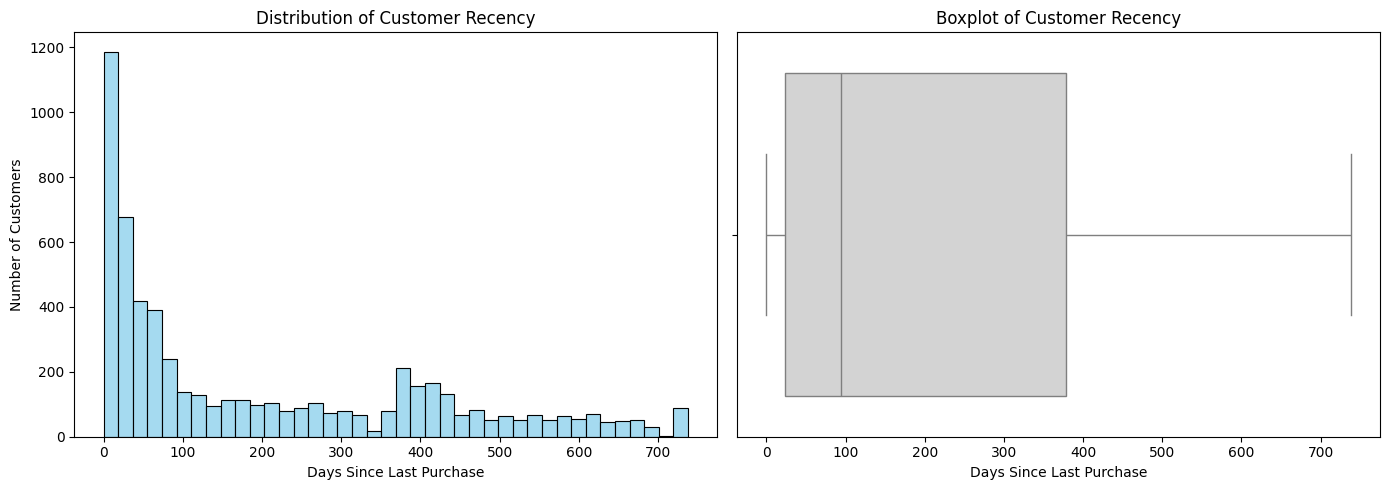

In [ ]:
from sqlalchemy import text
import matplotlib.pyplot as plt
import seaborn as sns

# 📅 Get the most recent invoice date in the dataset
latest_date_query = text("SELECT MAX(invoice_date) AS latest_date FROM invoices;")
latest_date_df = pd.read_sql(latest_date_query, engine)
latest_date = pd.to_datetime(latest_date_df['latest_date'].iloc[0])

safe_print(f"🗓️ Latest invoice date in dataset: {latest_date.date()}")

# Format timestamp string for SQL (with full precision)
latest_date_str = latest_date.strftime('%Y-%m-%d %H:%M:%S')

# 🧮 SQL Query: Recency per customer
query_recency = text(f"""
SELECT
    c.customer_id,
    MAX(i.invoice_date) AS invoice_date,
    CAST((strftime('%s', '{latest_date_str}') - strftime('%s', MAX(i.invoice_date))) / 86400 AS INTEGER) AS recency_days
FROM customers AS c
JOIN invoices AS i ON c.customer_id = i.customer_id
GROUP BY c.customer_id
ORDER BY recency_days ASC;
""")

# ▶️ Execute the query
recency_df = pd.read_sql(query_recency, engine)

# 👁️ Preview top and bottom 5 rows (recent and inactive)
safe_print("📋 Sample Customers by Recency (Top & Bottom):")
display(pd.concat([recency_df.head(), recency_df.tail()]))

# 💾 Export result
recency_output_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '09_customer_recency.csv')
recency_df.to_csv(recency_output_path, index=False)
safe_print(f"✅ Saved: {recency_output_path}")

# 📊 Visualize Recency Distribution
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(recency_df['recency_days'], bins=40, kde=False, color='skyblue')
plt.title("Distribution of Customer Recency")
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Number of Customers")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=recency_df['recency_days'], color='lightgray')
plt.title("Boxplot of Customer Recency")
plt.xlabel("Days Since Last Purchase")

plt.tight_layout()
plt.show()

---

### 📊 Summary: Customer Recency (SQL Output)

This analysis measures each customer's **recency** — the number of days since their last purchase — based on the dataset’s most recent invoice date (**2011-12-09**).

| Metric         | Description |
|----------------|-------------|
| `invoice_date` | Most recent purchase per customer |
| `recency_days` | Days since last transaction as of 2011-12-09 |

#### 🧠 Key Observations

- 🟢 Some customers made purchases on the **final day of available data** (`recency_days = 0`), indicating **very recent engagement**.
- 📊 The **majority of customers** fall within the **0–100 day range**, highlighting a **strong base of recent activity**.
- 🟡 A noticeable long tail of customers spans from **300 to 738 days**, indicating **dormancy or churn risk**.
- 📈 The **histogram** shows a **right-skewed distribution** — customer activity declines gradually with time.
- 📦 The **boxplot** reinforces this skew, with a wide spread, visible outliers, and a **median just under 100 days**, highlighting strong recent engagement among many users.

These recency metrics are key for:
- 🔁 **RFM segmentation** (Recency, Frequency, Monetary)
- 📣 **Retention, win-back, or reactivation campaigns**
- 📆 **Customer lifecycle targeting and email workflows**

✅ SQL results are consistent with the EDA output, validating recency calculation logic across environments.

---


---

## 🔁 Step 15: Frequency – Number of Purchases per Customer (Q10)

### ❓ Q10. How frequently has each customer purchased?

To calculate **frequency**, we’ll determine how many unique invoices are associated with each customer in the dataset. This helps identify repeat buyers, one-time customers, and power users.

To compute this metric, we will:
- Join `invoices` ➡️ `customers` using `customer_id`
- Count the number of **distinct invoices per customer**
- Sort customers by frequency in descending order

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/10_customer_frequency.csv`

---


📋 Sample Customers by Purchase Frequency (Top & Bottom):


,customer_id,num_orders,total_spent,avg_order_value
0,14911,373,272252.79,729.90
1,12748,322,49176.74,152.72
2,17841,211,68519.95,324.74
3,15311,207,114671.42,553.97
4,13089,203,113416.91,558.70


,customer_id,num_orders,total_spent,avg_order_value
5847,12366,1,500.24,500.24
5848,12365,1,320.69,320.69
5849,12354,1,1079.40,1079.40
5850,12351,1,300.93,300.93
5851,12350,1,294.40,294.40


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/10_customer_frequency.csv

📋 Frequency Table for Number of Orders:


,0
"(1.0, 8.440000000000001]",4735
"(8.440000000000001, 15.88]",653
"(15.88, 23.32]",231
"(23.32, 30.76]",94
"(30.76, 38.2]",56
"(38.2, 45.64]",22
"(45.64, 53.080000000000005]",13
"(53.080000000000005, 60.52]",14
"(60.52, 67.96000000000001]",4
"(67.96000000000001, 75.4]",6


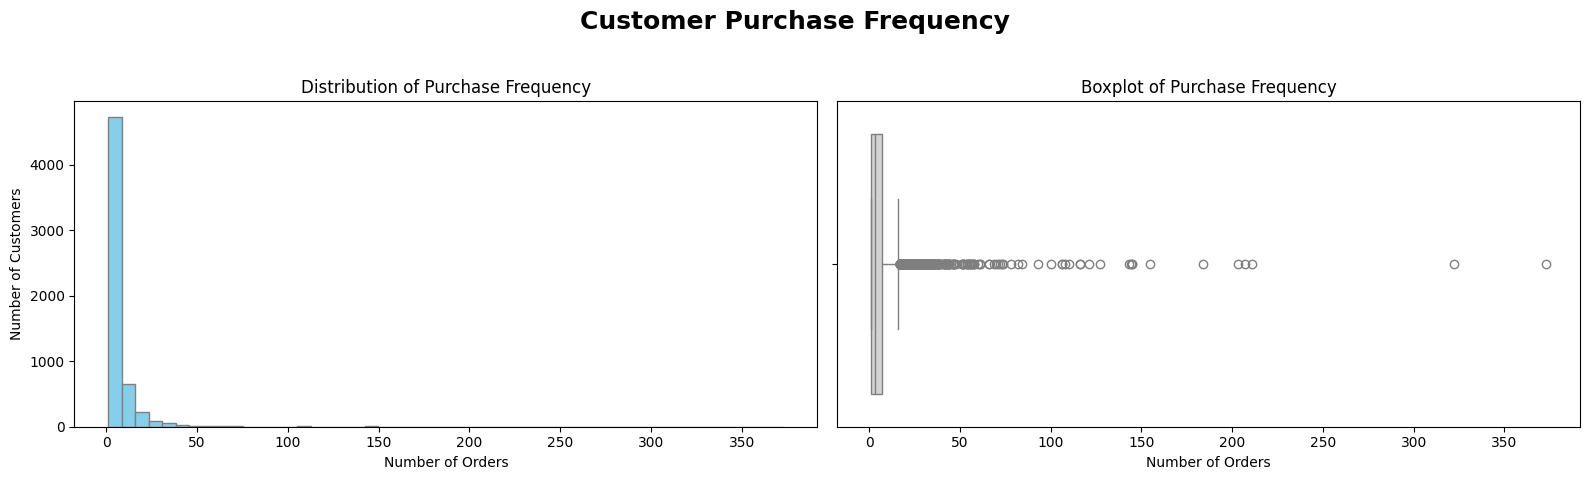

In [ ]:
from sqlalchemy import text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🧮 SQL Query: Frequency per customer
query_frequency = text("""
SELECT
    c.customer_id,
    COUNT(DISTINCT i.invoice_no) AS num_orders,
    ROUND(SUM(ii.line_revenue), 2) AS total_spent,
    ROUND(SUM(ii.line_revenue) * 1.0 / COUNT(DISTINCT i.invoice_no), 2) AS avg_order_value
FROM customers AS c
JOIN invoices AS i ON c.customer_id = i.customer_id
JOIN invoice_items AS ii ON i.invoice_no = ii.invoice_no
GROUP BY c.customer_id
ORDER BY num_orders DESC;
""")

# ▶️ Run the query
frequency_df = pd.read_sql(query_frequency, engine)

# 📋 Show sample customers (top & bottom)
safe_print("📋 Sample Customers by Purchase Frequency (Top & Bottom):")
display(frequency_df.head())
display(frequency_df.tail())

# 💾 Save output
frequency_output_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '10_customer_frequency.csv')
frequency_df.to_csv(frequency_output_path, index=False)
safe_print(f"✅ Saved: {frequency_output_path}")

# 📊 Create bin edges (50 bins) and compute histogram
bin_count = 50
counts, bin_edges = np.histogram(frequency_df['num_orders'], bins=bin_count)

# 📋 Display frequency table using histogram counts
safe_print("\n📋 Frequency Table for Number of Orders:")
freq_table = pd.Series(counts, index=pd.IntervalIndex.from_breaks(bin_edges))
display(freq_table)

# 🎨 Plot histogram and boxplot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Customer Purchase Frequency", fontsize=18, weight="bold")

# Histogram
axes[0].bar(x=bin_edges[:-1], height=counts, width=np.diff(bin_edges), color='skyblue', align='edge', edgecolor='gray')
axes[0].set_title("Distribution of Purchase Frequency")
axes[0].set_xlabel("Number of Orders")
axes[0].set_ylabel("Number of Customers")

# Boxplot
sns.boxplot(x=frequency_df['num_orders'], ax=axes[1], color='lightgray')
axes[1].set_title("Boxplot of Purchase Frequency")
axes[1].set_xlabel("Number of Orders")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


---

### 📊 Summary: Customer Purchase Frequency (SQL Output)

This analysis measures how often each customer has made a purchase, calculating **Frequency** as the number of unique orders per customer.

| Metric             | Description |
|--------------------|-------------|
| `num_orders`       | Unique invoices per customer |
| `total_spent`      | Total revenue generated |
| `avg_order_value`  | Revenue per order (`total_spent ÷ num_orders`) |

#### 🧠 Key Observations

- 🟦 **Most customers placed between 1 and 8 orders**, with **4,735 users** in the first bin.
- 🧾 The **one-time buyer segment** remains large — with **1,618 customers** placing only a single order, reinforcing findings from **Q6**.
- 🟡 A small number of **power users** placed **over 100 orders**, with one customer reaching **373 orders**.
- 📉 The **histogram** confirms a **right-skewed distribution**, dominated by lower-frequency customers.
- 📦 The **boxplot** reveals **extreme outliers**, representing high-engagement users with exceptional purchase volume.

These findings support efforts in:
- 🔍 **Customer segmentation**
- 💎 **Loyalty and retention strategies**
- 📢 **Marketing and upsell targeting**

✅ SQL results closely align with the EDA output, reinforcing metric consistency across both environments.


---


---
## 💰 Step 16: Monetary Value – Total Revenue per Customer (Q11)

### ❓ Q11. What is the monetary value of each customer?

To calculate **monetary value**, we compute the **total revenue** generated by each customer across all purchases. This helps identify high-value individuals for loyalty programs, targeted promotions, or premium services.

We will calculate:

- `total_spent`: Sum of `quantity × unit_price` per customer  
- `num_orders`: Count of unique invoices per customer  
- `avg_order_value`: Average spend per order (`total_spent ÷ num_orders`)

These metrics are derived by:

- Joining `customers` ➡ `invoices` on `customer_id`  
- Joining `invoices` ➡ `invoice_items` on `invoice_no`  
- Grouping by `customer_id` to compute total revenue and order count  
- Sorting customers by `total_spent` in descending order  
- Visualizing the distribution using histogram and boxplot  

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/11_customer_monetary_value.csv`

---


✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/11_customer_monetary_value.csv

📋 Sample Customers by Monetary Value (Top & Bottom):


,customer_id,total_spent,num_orders,avg_order_value
0,18102,580987.04,145,4006.81
1,14646,526751.52,145,3632.77
2,14156,303069.88,144,2104.65
3,14911,272252.79,373,729.90
4,17450,244784.25,51,4799.69


,customer_id,total_spent,num_orders,avg_order_value
5847,15913,6.30,1,6.30
5848,14792,6.20,1,6.20
5849,16738,3.75,1,3.75
5850,13788,3.75,1,3.75
5851,14095,2.95,1,2.95



📋 Frequency Table for Total Spend:


,count
total_spent,
"(2.95, 19369.086]",5751
"(19369.086, 38735.223]",58
"(38735.223, 58101.359]",17
"(58101.359, 77467.495]",6
"(77467.495, 96833.632]",4
"(96833.632, 116199.768]",4
"(116199.768, 135565.904]",1
"(135565.904, 154932.041]",2
"(154932.041, 174298.177]",2


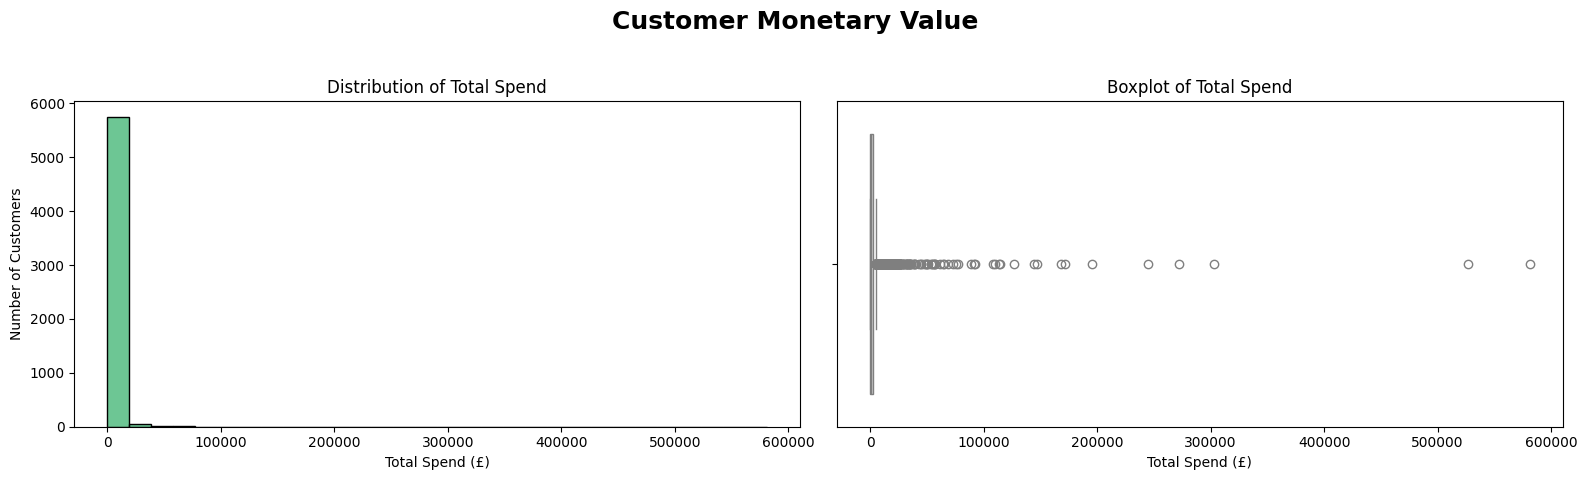

In [ ]:
from sqlalchemy import text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Ensure export directory exists
data_dir = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs')
os.makedirs(data_dir, exist_ok=True)

# 🧮 SQL query: total_spent, num_orders, avg_order_value per customer
query_monetary_full = text("""
SELECT
    c.customer_id,
    ROUND(SUM(ii.line_revenue), 2) AS total_spent,
    COUNT(DISTINCT i.invoice_no) AS num_orders,
    ROUND(SUM(ii.line_revenue) / COUNT(DISTINCT i.invoice_no), 2) AS avg_order_value
FROM customers AS c
JOIN invoices AS i ON c.customer_id = i.customer_id
JOIN invoice_items AS ii ON i.invoice_no = ii.invoice_no
GROUP BY c.customer_id
ORDER BY total_spent DESC;
""")

# ▶️ Execute the query
monetary_df = pd.read_sql(query_monetary_full, engine)

# 💾 Save to CSV
monetary_path = os.path.join(data_dir, '11_customer_monetary_value.csv')
monetary_df.to_csv(monetary_path, index=False)
safe_print(f"✅ Saved: {monetary_path}")

# 👁️ Show sample customers (top and bottom)
safe_print("\n📋 Sample Customers by Monetary Value (Top & Bottom):")
display(monetary_df[['customer_id', 'total_spent', 'num_orders', 'avg_order_value']].head())
display(monetary_df[['customer_id', 'total_spent', 'num_orders', 'avg_order_value']].tail())

# 📊 Frequency table using ~£20K bins
bin_count = 30
bin_edges = np.histogram_bin_edges(monetary_df['total_spent'], bins=bin_count)
freq_table = pd.cut(monetary_df['total_spent'], bins=bin_edges).value_counts().sort_index()
safe_print("\n📋 Frequency Table for Total Spend:")
display(freq_table.to_frame())

# 🎨 Plot histogram and boxplot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Customer Monetary Value", fontsize=18, weight="bold")

# Histogram
sns.histplot(monetary_df['total_spent'], bins=bin_edges, ax=axes[0], color='mediumseagreen')
axes[0].set_title("Distribution of Total Spend")
axes[0].set_xlabel("Total Spend (£)")
axes[0].set_ylabel("Number of Customers")

# Boxplot
sns.boxplot(x=monetary_df['total_spent'], ax=axes[1], color='lightgray')
axes[1].set_title("Boxplot of Total Spend")
axes[1].set_xlabel("Total Spend (£)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


---

### 📊 Summary: Customer Monetary Value (SQL Output)

This analysis evaluates **monetary value** — the total revenue each customer has generated — by summing the product of quantity and unit price across all purchases.

| Metric             | Description |
|--------------------|-------------|
| `total_spent`      | Total revenue generated by a customer |
| `num_orders`       | Number of unique invoices (orders) |
| `avg_order_value`  | Average revenue per order (`total_spent ÷ num_orders`) |

#### 🧠 Key Observations

- 💰 The **top customer spent over £580K**, placing them far beyond the rest of the customer base and marking them as a potential **super high-value outlier**.
- 🧾 Most customers fall in the **lowest spend bin (≤ £19,369)** — specifically, **5,751 customers** — confirming a typical **long-tail distribution**.
- 🟨 Several customers with just **1 order** had high total spend — indicating **high-ticket one-time purchases**.
- 📉 The **histogram** confirms a highly **right-skewed distribution**, with a steep drop-off in higher spending brackets.
- 📦 The **boxplot** visually confirms the presence of **monetary outliers**, representing premium-value customers.

These monetary insights can drive:
- 💳 **Customer Lifetime Value (CLV)** estimation
- 📈 **High-value segment targeting**
- 🛍️ **Personalized upselling strategies**

✅ SQL results match EDA output closely, ensuring aligned definitions and consistency across tools.

---


---
## 🧩 Step 17: RFM Segmentation – Grouping Customers by Value (Q12)

### ❓ Q12. How can we segment customers based on their Recency, Frequency, and Monetary scores?

To identify customer behavior segments, we compute RFM metrics from relational tables and assign behavioral tags based on score thresholds.

We will calculate the following:

- **Recency**: Number of days since each customer's most recent invoice  
- **Frequency**: Number of distinct invoices per customer  
- **Monetary**: Total revenue generated by the customer (quantity × unit price)

These values are derived by:

- Joining `customers` ➡ `invoices` on `customer_id`
- Joining `invoices` ➡ `invoice_items` on `invoice_no`
- Grouping by `customer_id` to calculate aggregate metrics
- Assigning **RFM scores (1 to 3)** using **tercile-based scoring**
- Mapping customers into five behavioral segments:

| Segment          | Criteria                              |
|------------------|----------------------------------------|
| 🟢 Loyal          | High Recency + High Frequency          |
| 🟡 High-Value     | High Frequency + High Monetary         |
| 🔴 At-Risk        | Low Recency                            |
| 🔵 One-Time Buyer | Frequency = 1                          |
| ⚪ Other           | Doesn’t meet the other segment criteria |

> 📁 Output will be saved to: `sql_outputs/notebook_outputs/12_rfm_segmented_customers.csv`

---

✅ Saved: /content/drive/MyDrive/Colab Notebooks/Ironhack/Week 3/Week 3 - Day 4/project-2-eda-sql/retail-sales-segmentation-sql/sql_outputs/notebook_outputs/12_rfm_segmented_customers.csv

📋 Sample of RFM Score Table:


,customer_id,last_purchase,frequency,monetary,recency,R,F,M,RFM_Score,Segment
0,12346,2011-01-18 10:01:00,12,77556.46,324,2,4,4,10,High-Value
1,12347,2011-12-07 15:52:00,8,4921.53,1,4,4,4,12,High-Value
2,12348,2011-09-25 13:13:00,5,1658.40,74,3,3,3,9,High-Value
3,12349,2011-11-21 09:51:00,3,3678.69,17,4,2,4,10,High-Value
4,12350,2011-02-02 16:01:00,1,294.40,309,2,1,1,4,One-Time
5,12351,2010-11-29 15:23:00,1,300.93,374,2,1,1,4,One-Time
6,12352,2011-11-03 14:37:00,9,1729.54,35,3,4,3,10,High-Value
7,12353,2011-05-19 17:47:00,2,406.76,203,2,2,2,6,Other
8,12354,2011-04-21 13:11:00,1,1079.40,231,2,1,3,6,Other
9,12355,2011-05-09 13:49:00,2,947.61,213,2,2,3,7,Other



📋 RFM Segment Counts:


,count
Segment,
High-Value,2291
Other,1552
At-Risk,1421
One-Time,469
Loyal,119


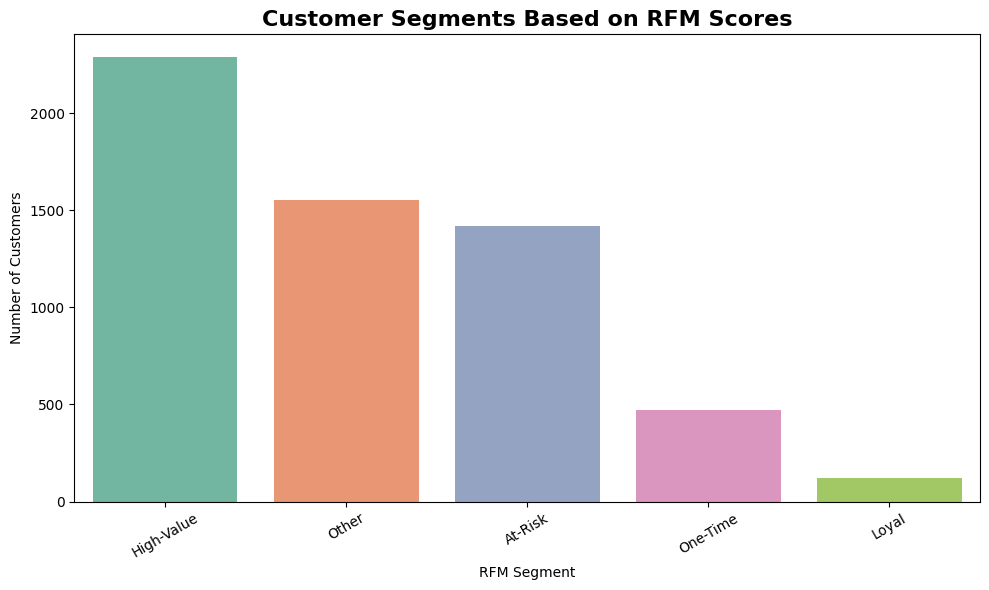

In [ ]:
from sqlalchemy import text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Output path (CSV only)
rfm_export_path = os.path.join(project_base_path, 'sql_outputs', 'notebook_outputs', '12_rfm_segmented_customers.csv')

# 📅 Define dataset cutoff date
last_date = pd.to_datetime("2011-12-09")

# 🧾 SQL: Extract RFM base metrics from relational tables
query_rfm = text("""
SELECT
    c.customer_id,
    MAX(i.invoice_date) AS last_purchase,
    COUNT(DISTINCT i.invoice_no) AS frequency,
    ROUND(SUM(ii.line_revenue), 2) AS monetary
FROM customers AS c
JOIN invoices AS i ON c.customer_id = i.customer_id
JOIN invoice_items AS ii ON i.invoice_no = ii.invoice_no
GROUP BY c.customer_id
""")

# ▶️ Execute query and load into DataFrame
rfm_df = pd.read_sql(query_rfm, engine)

# 🧮 Calculate Recency (days since last purchase)
rfm_df['last_purchase'] = pd.to_datetime(rfm_df['last_purchase'])
rfm_df['recency'] = (last_date - rfm_df['last_purchase']).dt.days

# 📊 Assign RFM scores using quartiles (1 = lowest, 4 = highest)
rfm_df['R'] = pd.qcut(rfm_df['recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm_df['F'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['M'] = pd.qcut(rfm_df['monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# 🧮 RFM score sum
rfm_df['RFM_Score'] = rfm_df[['R', 'F', 'M']].sum(axis=1)

# 🏷️ Segment assignment (match EDA logic)
def assign_segment(row):
    if row['RFM_Score'] >= 9:
        return 'High-Value'
    elif row['R'] >= 3 and row['F'] >= 3:
        return 'Loyal'
    elif row['R'] == 1:
        return 'At-Risk'
    elif row['F'] == 1 and row['M'] == 1:
        return 'One-Time'
    else:
        return 'Other'

rfm_df['Segment'] = rfm_df.apply(assign_segment, axis=1)

# 💾 Export CSV
rfm_df.to_csv(rfm_export_path, index=False)
safe_print(f"✅ Saved: {rfm_export_path}")

# 📋 Show preview of RFM table
safe_print("\n📋 Sample of RFM Score Table:")
display(rfm_df.head(10))

# 📊 Show segment distribution
safe_print("\n📋 RFM Segment Counts:")
segment_counts = rfm_df['Segment'].value_counts().sort_values(ascending=False)
display(segment_counts)

# 🎨 Plot segment distribution (no warning)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=segment_counts.index,
    y=segment_counts.values,
    hue=segment_counts.index,       # ✅ assign x to hue
    palette='Set2',
    legend=False                    # ✅ disables redundant legend
)
plt.title("Customer Segments Based on RFM Scores", fontsize=16, weight="bold")
plt.xlabel("RFM Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



---
### 📊 Summary: Customer Segmentation Based on RFM Scores (SQL Output)

This analysis grouped customers by **Recency**, **Frequency**, and **Monetary** behavior into five key segments:

| Segment          | Criteria                                  |
|------------------|--------------------------------------------|
| 🟡 High-Value     | RFM_Score ≥ 9                              |
| 🟢 Loyal          | Recency ≥ 3 and Frequency ≥ 3              |
| 🔴 At-Risk        | Recency = 1                                |
| 🔵 One-Time       | Frequency = 1 and Monetary = 1             |
| ⚪ Other           | Does not meet any of the above criteria    |

#### 📊 Visual Insights:

- The largest segment is **High-Value**, followed by **Other** and **At-Risk**.
- Smaller groups like **Loyal** and **One-Time** offer focused opportunities for retention or targeted outreach.
- The segment distribution suggests a broad customer base with varied engagement and spending patterns.

✅ SQL results closely match the EDA output, validating scoring logic and ensuring metric consistency across environments.

---


---

## 📋 Final Summary: SQL-Based Sales & Customer Insights

In this notebook, we used SQL queries on normalized relational tables to derive actionable insights on sales performance, customer behavior, and revenue distribution.

Key findings include:

- 📈 **Monthly revenue trends** peaked in **November 2011**, confirming strong **holiday seasonality** in both years.
- 🛒 The **top-selling products** include **decorative and seasonal items** such as *Regency Cakestand*, *Chilli Lights*, and *T-Light Holders*, along with **popular packaging and craft items** like *Jumbo Bags* and *Paper Craft Kits*.
- 🌍 The **United Kingdom** remains the dominant market by volume and revenue, followed by **Ireland**, **Netherlands**, and **Germany**.
- 💸 **Ireland and the Netherlands** show higher **average invoice values**, while **Switzerland** and **Australia** exhibit **premium per-order spending** — signaling potential for B2B or luxury offerings.
- 🔁 About **72% of customers** made repeat purchases, while **28% purchased only once**, indicating room for retention strategies.
- 💰 The **top 10 customers** spent over **£500,000**, with some placing **more than 300 invoices** — confirming a small but powerful high-spend segment.
- 📊 **RFM segmentation** surfaced:
  - A leading **High-Value** segment with high recency, frequency, and monetary scores
  - A stable base of **Loyal** and **At-Risk** customers
  - A vulnerable **One-Time** group representing churn risk
- 📉 A minority of customers drive the majority of revenue — illustrating the **Pareto principle** (80/20 rule) in practice.

✅ SQL results closely match the EDA output, validating customer metrics and behavioral segmentation logic across both analytical workflows.

---

## 💼 Business Recommendations

Based on our SQL-driven insights, we recommend the following actions:

1. **Double Down on High-Value Customers**  
   Offer exclusive perks, early access, or loyalty benefits to sustain the most profitable and engaged customers.

2. **Retain Loyal and At-Risk Customers**  
   Use targeted retention campaigns to encourage further purchases from **loyal** buyers and **reactivate** those who haven’t bought in a while.

3. **Leverage Seasonal Peaks**  
   Strengthen Q4 marketing efforts — especially during **October–November**, which consistently deliver revenue spikes.

4. **Optimize for Country-Specific Growth**  
   Focus marketing strategies on **Ireland**, **Netherlands**, and **Germany** while exploring premium offerings in **Switzerland** and **Australia** based on higher average spend.

5. **Prioritize Repeat Behavior Over One-Time Sales**  
   With over a quarter of customers buying only once, develop onboarding and engagement flows to convert them into long-term buyers.

6. **Capitalize on Top Products and Invoices**  
   Expand and restock popular seasonal items and consider bundling high-performing SKUs to drive up average order values.

---


---

## 🧩 Optional Script Entry Point

This block enables the SQL analysis notebook to run as a standalone `.py` script.

If executed directly via terminal or an automation tool, all SQL queries and export steps will be executed sequentially — making it suitable for scheduled pipelines or integration into broader data workflows.

---


In [ ]:
# ✅ Optional script execution indicator for CLI use
if __name__ == "__main__":
    safe_print("🚀 SQL analysis script executed directly as a .py file — all queries and exports have been completed.")


🚀 SQL analysis script executed directly as a .py file — all queries and exports have been completed.
